In [ ]:
!unzip problems.zip

Archive:  problems.zip
replace problems/occlusion2.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [89]:
import numpy as np
import pandas as pd
from math import sqrt, pi
from scipy.optimize import minimize
from scipy.optimize import leastsq
from skimage.measure import EllipseModel
from scipy.spatial import ConvexHull
from skimage import transform
import cv2, csv
from scipy.optimize import curve_fit
from scipy.interpolate import splprep, splev
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# Read and process the CSV file
csv_path = "/content/problems/frag0.csv"
output_data = read_csv(csv_path)

df = pd.read_csv('/content/problems/frag0.csv')

In [90]:
df

,0.000000000000000000e+00,0.000000000000000000e+00.1,4.194200134277343750e+01,6.898000335693359375e+01
0,0.0,0.0,41.259605,69.811707
1,0.0,0.0,40.588753,70.652374
2,0.0,0.0,39.929607,71.501953
3,0.0,0.0,39.282337,72.360405
4,0.0,0.0,38.647114,73.227669
...,...,...,...,...
1769,9.0,0.0,212.755249,2.102682
1770,9.0,0.0,213.760941,2.103762
1771,9.0,0.0,214.766632,2.104841
1772,9.0,0.0,215.772308,2.105921


In [91]:
len(output_data)

10

In [92]:
for i in range(len(output_data)):
  print(output_data[i][0].shape)

(94, 2)
(166, 2)
(171, 2)
(166, 2)
(109, 2)
(205, 2)
(226, 2)
(208, 2)
(215, 2)
(215, 2)


In [206]:
import numpy as np
import pandas as pd
from scipy.spatial import ConvexHull
from scipy.interpolate import splprep, splev
from skimage.measure import EllipseModel

def regularize_rounded_rectangle(points):
    min_corner = np.min(points, axis=0)
    max_corner = np.max(points, axis=0)
    rect_width = max_corner[0] - min_corner[0]
    rect_height = max_corner[1] - min_corner[1]

    radius = min(rect_width, rect_height) * 0.1

    corner_points = [
        [min_corner[0] + radius, min_corner[1] + radius],
        [max_corner[0] - radius, min_corner[1] + radius],
        [max_corner[0] - radius, max_corner[1] - radius],
        [min_corner[0] + radius, max_corner[1] - radius]
    ]

    points_per_corner = 10
    x_coords, y_coords = [], []
    for i in range(4):
        start = np.array(corner_points[i])
        end = np.array(corner_points[(i + 1) % 4])
        interpolated_points = np.linspace(start, end, points_per_corner, endpoint=False)
        if i == 0:
            interpolated_points[0] = start
        x_coords.extend(interpolated_points[:, 0])
        y_coords.extend(interpolated_points[:, 1])

    x_coords.append(corner_points[0][0])
    y_coords.append(corner_points[0][1])

    return np.column_stack((x_coords, y_coords))

def regularize_polygon(points):
    centroid = np.mean(points, axis=0)
    avg_radius = np.mean(np.linalg.norm(points - centroid, axis=1))
    num_sides = len(points)

    if num_sides < 3:
        return np.array([])

    angle_step = np.linspace(0, 2 * np.pi, num_sides, endpoint=False)
    x_coords = centroid[0] + avg_radius * np.cos(angle_step)
    y_coords = centroid[1] + avg_radius * np.sin(angle_step)

    x_coords = np.append(x_coords, x_coords[0])
    y_coords = np.append(y_coords, y_coords[0])

    return np.column_stack((x_coords, y_coords))

def regularize_line(points):
    if len(points) < 2:
        return np.array([])

    start_point, end_point = points[0], points[-1]
    x_coords = np.array([start_point[0], end_point[0]])
    y_coords = np.array([start_point[1], end_point[1]])

    return np.column_stack((x_coords, y_coords))

def regularize_ellipse(points):
    if len(points) < 5:
        return np.array([])

    ellipse_model = EllipseModel()
    if not ellipse_model.estimate(points):
        return np.array([])

    center_x, center_y, semi_major, semi_minor, angle = ellipse_model.params
    num_samples = len(points)
    angles = np.linspace(0, 2 * np.pi, num_samples)
    x_coords = center_x + semi_major * np.cos(angles) * np.cos(angle) - semi_minor * np.sin(angles) * np.sin(angle)
    y_coords = center_y + semi_major * np.cos(angles) * np.sin(angle) + semi_minor * np.sin(angles) * np.cos(angle)

    return np.column_stack((x_coords, y_coords))

def regularize_circle(points, max_width, max_height, scale_ratio=0.9):
    center = np.mean(points, axis=0)
    avg_radius = np.median(np.linalg.norm(points - center, axis=1))

    min_dim = min(max_width, max_height)
    scale = (min_dim * scale_ratio) / (2 * avg_radius)

    num_points = len(points)
    angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    x_coords = center[0] + avg_radius * scale * np.cos(angles)
    y_coords = center[1] + avg_radius * scale * np.sin(angles)

    return np.column_stack((x_coords, y_coords))

def regularize_rectangle(points, max_width, max_height, scale_ratio=0.9):
    min_point = np.min(points, axis=0)
    max_point = np.max(points, axis=0)

    rect_width = max_point[0] - min_point[0]
    rect_height = max_point[1] - min_point[1]

    scale_x = (max_width * scale_ratio) / rect_width
    scale_y = (max_height * scale_ratio) / rect_height

    center = np.mean(points, axis=0)

    x_coords = [min_point[0], max_point[0], max_point[0], min_point[0], min_point[0]]
    y_coords = [min_point[1], min_point[1], max_point[1], max_point[1], min_point[1]]

    x_coords = center[0] + (np.array(x_coords) - center[0]) * scale_x
    y_coords = center[1] + (np.array(y_coords) - center[1]) * scale_y

    return np.column_stack((x_coords, y_coords))

def regularize_star(points):
    center = np.mean(points, axis=0)
    max_radius = np.max(np.linalg.norm(points - center, axis=1))
    inner_radius = max_radius * 0.4

    num_points = 10
    angle_steps = np.linspace(0, 2 * np.pi, num_points, endpoint=False)
    radii = np.zeros(num_points)
    radii[::2] = max_radius
    radii[1::2] = inner_radius

    x_coords = center[0] + radii * np.cos(angle_steps)
    y_coords = center[1] + radii * np.sin(angle_steps)

    x_coords = np.append(x_coords, x_coords[0])
    y_coords = np.append(y_coords, y_coords[0])

    return np.column_stack((x_coords, y_coords))

def bezier_curve_fit(points, num_points=100):
    spline_params, spline_u = splprep(points.T, s=0)
    new_u = np.linspace(spline_u.min(), spline_u.max(), num_points)
    x_new, y_new = splev(new_u, spline_params, der=0)
    return np.column_stack((x_new, y_new))

def calculate_perimeter(hull):
    perimeter = 0
    for i in range(len(hull.vertices)):
        p1 = hull.points[hull.vertices[i]]
        p2 = hull.points[hull.vertices[(i + 1) % len(hull.vertices)]]
        perimeter += np.linalg.norm(p1 - p2)
    return perimeter

def calculate_num_vertices(points):
    hull = ConvexHull(points)
    return len(hull.vertices)

def calculate_aspect_ratio(points):
    hull = ConvexHull(points)
    hull_points = hull.points[hull.vertices]
    distances = [np.linalg.norm(hull_points[i] - hull_points[(i + 1) % len(hull_points)]) for i in range(len(hull_points))]
    width, height = sorted(distances)[:2]
    return max(width, height) / min(width, height)

def calculate_max_extents(points):
    min_point = np.min(points, axis=0)
    max_point = np.max(points, axis=0)
    width = max_point[0] - min_point[0]
    height = max_point[1] - min_point[1]
    return width, height


In [95]:
import numpy as np

def regularize_path_with_connection(path, connection_threshold=5):
    """
    Regularizes and connects lines within the path, ensuring they align at 90 degrees, are connected,
    and adjusted to their full length based on the doodle, while handling bends and irregularities.
    """
    def extend_line(p1, p2, length):
        """Extend or shorten the line segment to the desired length."""
        line_vector = np.array(p2) - np.array(p1)
        line_length = np.linalg.norm(line_vector)
        unit_vector = line_vector / line_length
        new_p2 = np.array(p1) + unit_vector * length
        return p1, new_p2

    def adjust_line(p1, p2, min_p1, max_p2):
        """Adjust the line segment to fit within the bounding box."""
        if p1[0] < min_p1[0] or p1[1] < min_p1[1] or p2[0] > max_p2[0] or p2[1] > max_p2[1]:
            length = np.linalg.norm(np.array(p2) - np.array(p1))
            p1, p2 = extend_line(p1, p2, length)
        return p1, p2

    def fit_line(p1, p2):
        """Fit a line segment to be horizontal or vertical, based on the bounding box dimensions."""
        min_coords = np.min([p1, p2], axis=0)
        max_coords = np.max([p1, p2], axis=0)
        width = max_coords[0] - min_coords[0]
        height = max_coords[1] - min_coords[1]

        if width > height:
            return [min_coords[0], p1[1]], [max_coords[0], p1[1]]
        else:
            return [p1[0], min_coords[1]], [p1[0], max_coords[1]]

    def is_close(p1, p2, threshold):
        """Check if two points are within a threshold distance."""
        return np.linalg.norm(np.array(p1) - np.array(p2)) <= threshold

    regularized_path = []

    # Calculate the bounding box for connecting lines
    all_points = [p for shape in path for p in shape]
    min_coords = np.min(all_points, axis=0)
    max_coords = np.max(all_points, axis=0)

    for shape in path:
        if len(shape) < 2:
            continue  # Skip shapes with fewer than 2 points

        # Extract points and fit lines
        points = np.array(shape)
        min_p1 = [min_coords[0], min_coords[1]]
        max_p2 = [max_coords[0], max_coords[1]]

        p1, p2 = points[0], points[-1]
        p1, p2 = fit_line(p1, p2)
        p1, p2 = adjust_line(p1, p2, min_p1, max_p2)
        regularized_path.append([p1, p2])

    # Connect the lines
    connected_path = []
    for i in range(len(regularized_path)):
        if i > 0:
            prev_end = np.array(connected_path[-1][-1])
            curr_start = np.array(regularized_path[i][0])
            if is_close(prev_end, curr_start, connection_threshold):
                connected_path[-1][-1] = curr_start  # Connect the lines
                connected_path[-1] = np.vstack([connected_path[-1], regularized_path[i]])
            else:
                connected_path.append(regularized_path[i])
        else:
            connected_path.append(regularized_path[i])

    return connected_path


In [212]:
def is_line(points, tolerance=1e-2):
    """Check if the points form a line within a given tolerance."""
    if len(points) < 2:
        return False

    # Calculate the difference vectors between consecutive points
    diffs = np.diff(points, axis=0)

    # Normalize these difference vectors
    norms = np.linalg.norm(diffs, axis=1)
    unit_vectors = diffs / norms[:, np.newaxis]

    # Calculate the angles between consecutive unit vectors
    angles = np.arccos(np.clip(np.sum(unit_vectors[:-1] * unit_vectors[1:], axis=1), -1.0, 1.0))

    # Check if all angles are within the tolerance (i.e., close to 0)
    return np.all(np.abs(angles) < tolerance)

def regularize_shape(points):
    """Regularize the shape based on its type."""
    if len(points) == 0:
        return np.array([])  # Return empty array for empty input

    # Determine the maximum extents from the irregular shape
    max_width, max_height = calculate_max_extents(points)

    shape_type = identify_shape(points)

    if shape_type == 'line':
        return regularize_path_with_connection([points])[0]  # Regularize detected lines
    elif shape_type == 'circle':
        return regularize_circle(points, max_width, max_height)
    elif shape_type == 'rectangle':
        return regularize_rectangle(points, max_width, max_height)
    elif shape_type == 'star':
        return regularize_star(points)
    else:
        return bezier_curve_fit(points)  # Handle unknown or complex shapes


In [222]:
import numpy as np
import cv2

def calculate_angle(p1, p2, p3):
    """Calculate the angle between three points."""
    v1 = p1 - p2
    v2 = p3 - p2
    return np.degrees(np.arccos(np.clip(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)), -1.0, 1.0)))

def calculate_num_vertices(points, epsilon=0.02):
    """Calculate the number of vertices in the simplified contour."""
    # Convert points to a 2D array with type float32
    points = np.array(points, dtype=np.float32)

    # Calculate the perimeter of the contour
    epsilon = epsilon * cv2.arcLength(points, True)

    # Approximate the contour to reduce the number of vertices
    approx_curve = cv2.approxPolyDP(points, epsilon, True)

    return len(approx_curve), approx_curve

def calculate_perimeter(points):
    """Calculate the perimeter of the polyline."""
    perimeter = 0
    for i in range(len(points)):
        perimeter += np.linalg.norm(points[i] - points[(i + 1) % len(points)])
    return perimeter

def identify_shape(points):
    """Identify the shape based on the given points."""
    if len(points) < 3:
        return 'unknown'  # Not enough points to determine shape

    if is_line(points):
        return 'line'

    hull = ConvexHull(points)
    hull_area = hull.volume
    hull_perimeter = calculate_perimeter(hull.points[hull.vertices])

    if hull_perimeter == 0:
        return 'unknown'

    compactness = 4 * np.pi * hull_area / (hull_perimeter ** 2)
    aspect_ratio = calculate_aspect_ratio(points)
    num_vertices, approx_curve = calculate_num_vertices(points)

    if compactness > 0.8 and num_vertices > 6:
        return 'circle'

    if num_vertices == 4 and aspect_ratio > 0.8 and aspect_ratio < 1.2:
        return 'rectangle'

    if num_vertices > 5:
        # Check for star characteristics
        angles = [calculate_angle(approx_curve[i-1][0], approx_curve[i][0], approx_curve[(i+1) % num_vertices][0])
                  for i in range(num_vertices)]
        sharp_angles = [angle for angle in angles if angle < 45]  # Stars often have sharp angles
        if len(sharp_angles) >= 5:  # Threshold for considering a shape as a star
            return 'star'

    return 'unknown'

In [97]:
def save_to_csv(regularized_paths, output_csv_path):
    """Save the regularized paths to a CSV file."""
    rows = []
    for i, path in enumerate(regularized_paths):
        for j, shape in enumerate(path):
            for point in shape:
                # Append each point as a new row
                rows.append([i + 1, j + 1, point[0], point[1]])

    # Convert rows to a NumPy array for saving
    rows = np.array(rows)

    # Save to CSV
    np.savetxt(output_csv_path, rows, delimiter=',', fmt='%.6f',
               header='PathID,ShapeID,X,Y', comments='')

In [223]:
pathXY = read_csv('/content/problems/frag1.csv')

# Process and regularize shapes
regularized_path_XYs = []
for path in pathXY:
    regularized_path = []
    for shape in path:
        regularized_shape = regularize_shape(np.array(shape))
        regularized_path.append(regularized_shape)
    regularized_path_XYs.append(regularized_path)

# Save regularized shapes to CSV
save_to_csv(regularized_path_XYs, 'regularized_shapes.csv')

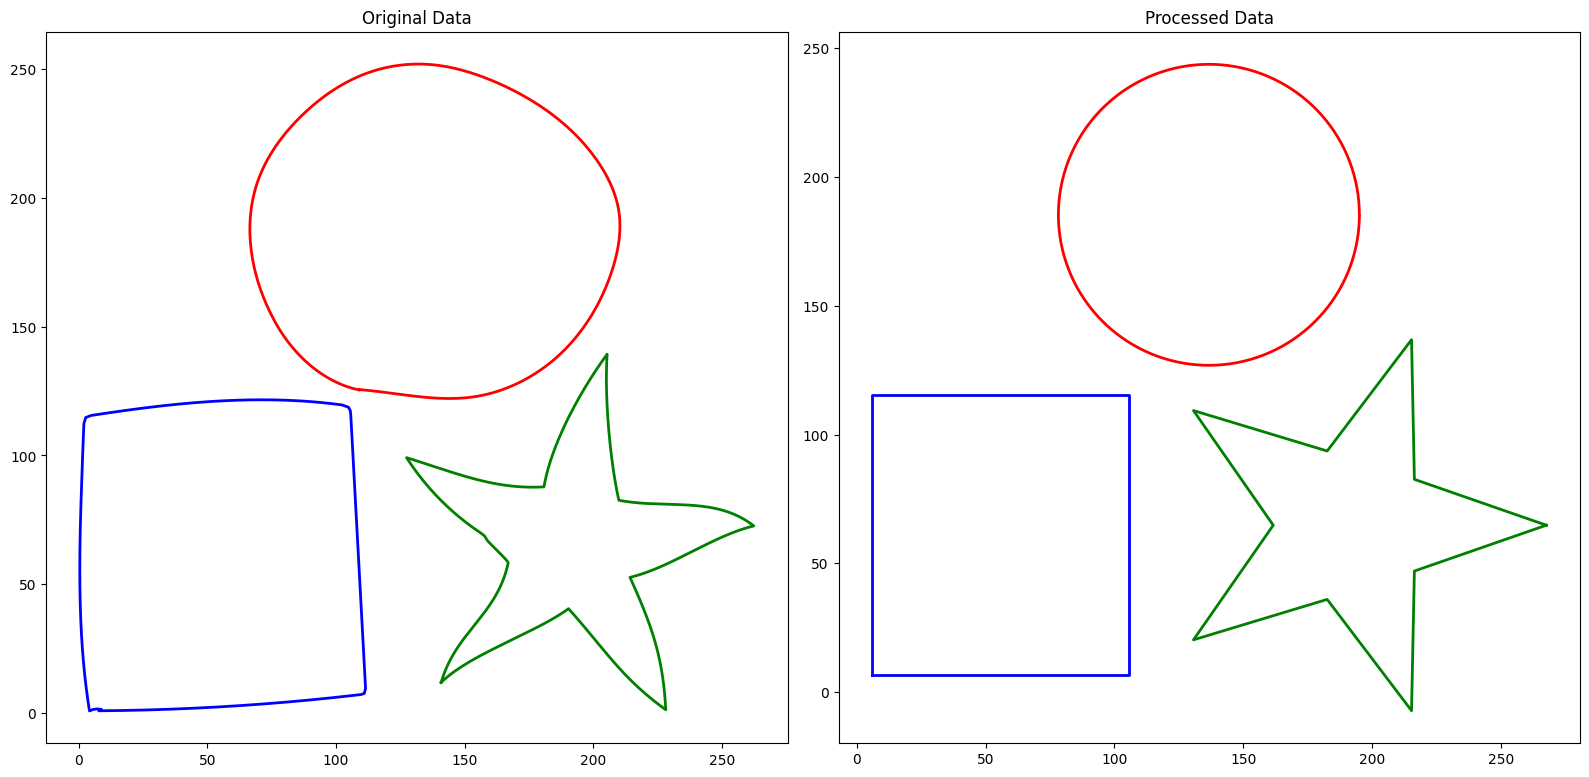

In [193]:
import numpy as np
import matplotlib.pyplot as plt

def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, title, ax):
    colours = ['red', 'green', 'blue', 'yellow', 'purple']  # Define some colors for plotting
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)

# Read and process the CSV files
csv_path1 = "/content/problems/isolated.csv"
csv_path2 = "/content/regularized_shapes.csv"

output_data1 = read_csv_(csv_path1)
output_data2 = read_csv_(csv_path2)

# Plot side by side
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(output_data1, 'Original Data', axs[0])
plot(output_data2, 'Processed Data', axs[1])
plt.show()


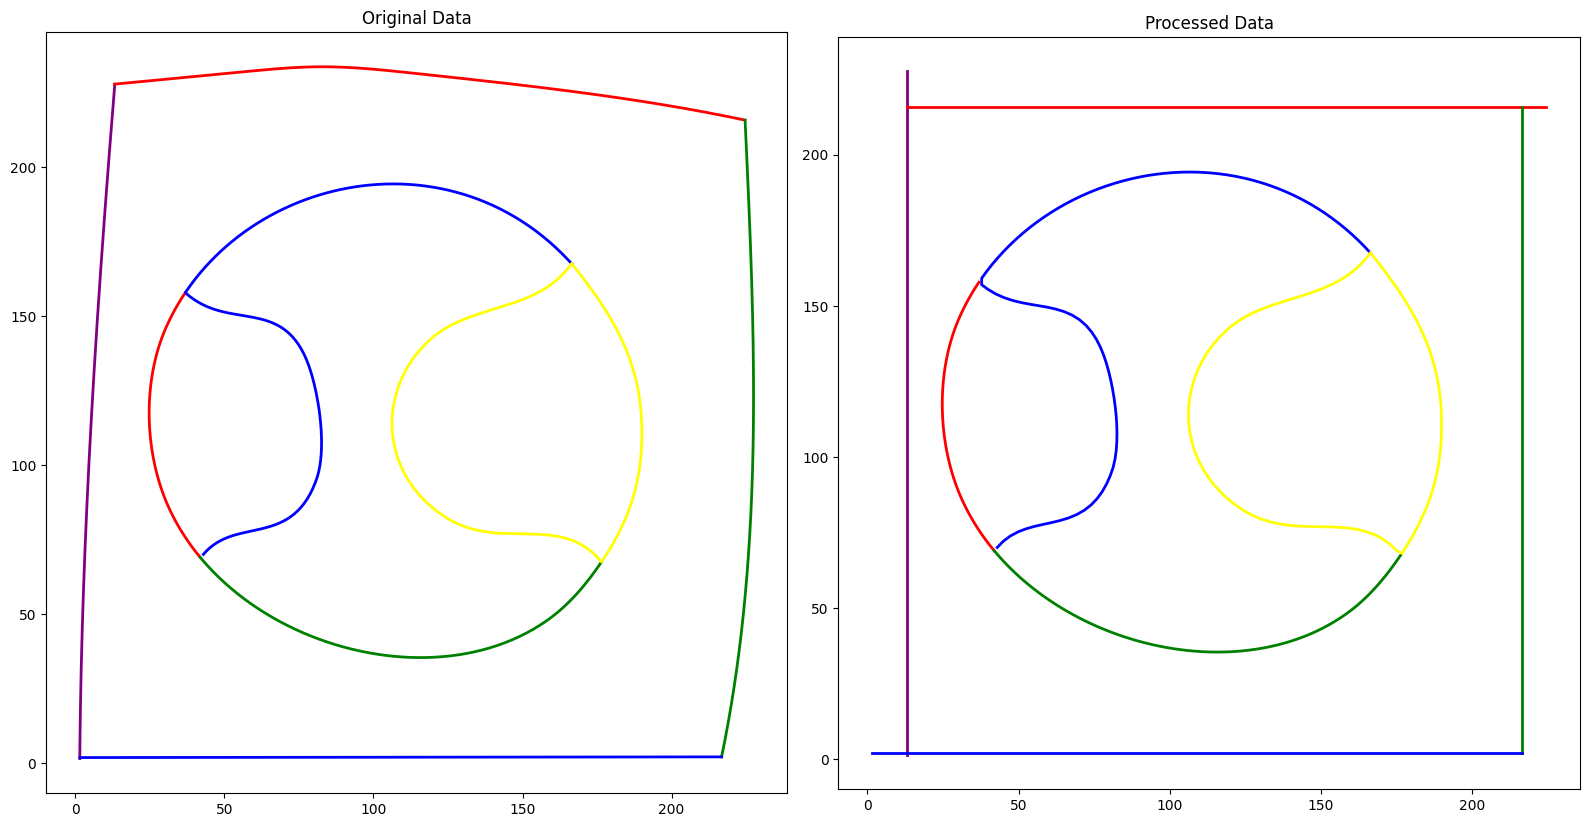

In [225]:
import numpy as np
import matplotlib.pyplot as plt

def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, title, ax):
    colours = ['red', 'green', 'blue', 'yellow', 'purple']  # Define some colors for plotting
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)

# Read and process the CSV files
csv_path1 = "/content/problems/frag1.csv"
csv_path2 = "/content/regularized_shapes.csv"

output_data1 = read_csv_(csv_path1)
output_data2 = read_csv_(csv_path2)

# Plot side by side
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(output_data1, 'Original Data', axs[0])
plot(output_data2, 'Processed Data', axs[1])
plt.show()

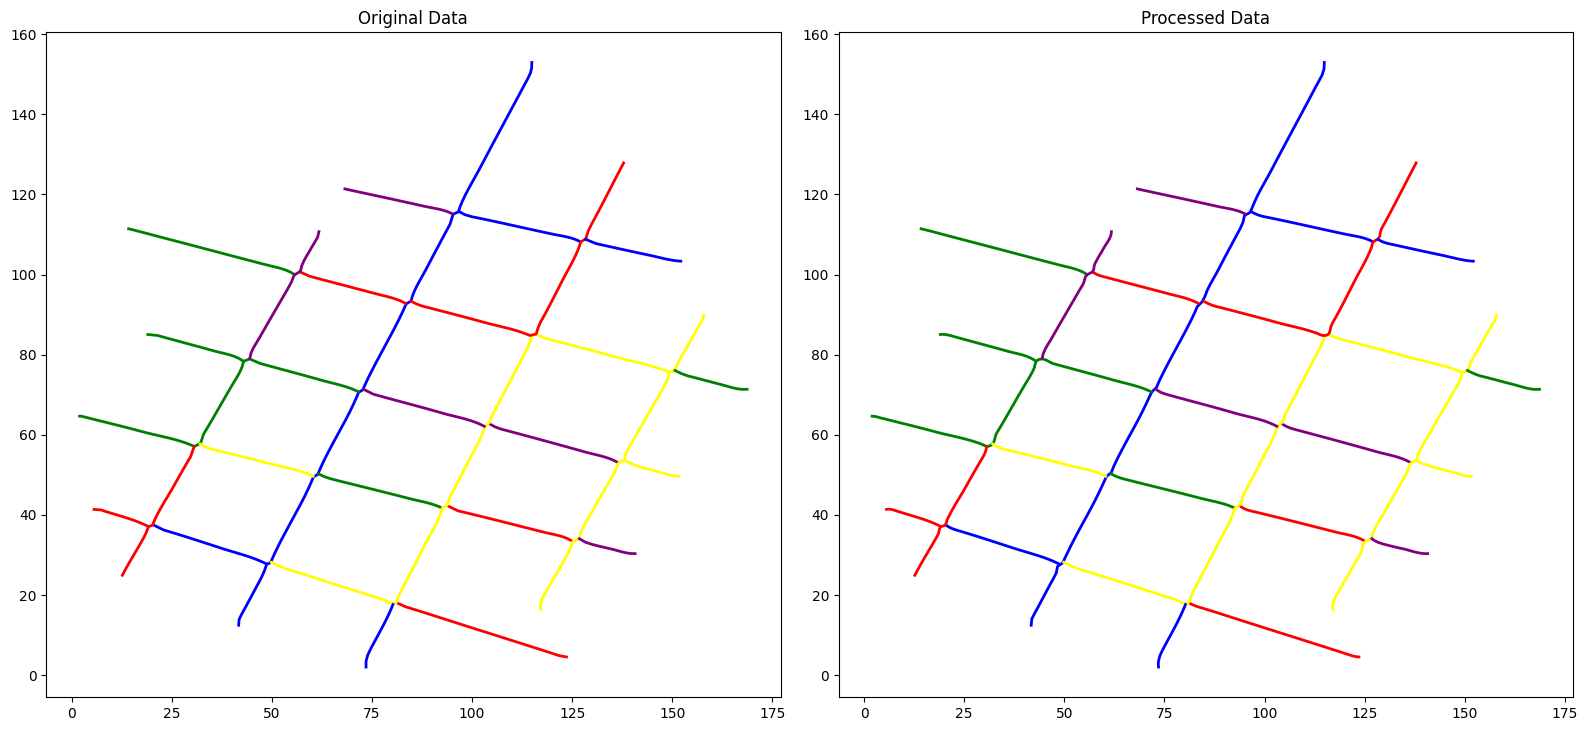

In [196]:
import numpy as np
import matplotlib.pyplot as plt

def read_csv_(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

def plot(paths_XYs, title, ax):
    colours = ['red', 'green', 'blue', 'yellow', 'purple']  # Define some colors for plotting
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
    ax.set_aspect('equal')
    ax.set_title(title)

# Read and process the CSV files
csv_path1 = "/content/problems/frag2.csv"
csv_path2 = "/content/regularized_shapes.csv"

output_data1 = read_csv_(csv_path1)
output_data2 = read_csv_(csv_path2)

# Plot side by side
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
plot(output_data1, 'Original Data', axs[0])
plot(output_data2, 'Processed Data', axs[1])
plt.show()
